In [18]:
import os
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
from sklearn.cluster import KMeans
from openai import OpenAI
import os
import json

client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))


ext_emb_path = ('data/css_speaker_topic_embeddings.csv')
emb_path = ('data/css_topic_embeddings.csv')

In [21]:
def plot(df_emb, n_clusters):
    df_emb["embedding"] = df_emb.embedding.apply(literal_eval).apply(np.array)  # convert string to numpy array
    matrix = np.vstack(df_emb.embedding.values)
    matrix.shape    
    # https://cookbook.openai.com/examples/clustering

    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
    kmeans.fit(matrix)
    labels = kmeans.labels_
    df_emb["Cluster"] = labels
    # df_emb.columns


    tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
    vis_dims2 = tsne.fit_transform(matrix)

    x = [x for x, y in vis_dims2]
    y = [y for x, y in vis_dims2]

    for category, color in enumerate(["purple", "green", "red", "blue"]):
        xs = np.array(x)[df_emb.Cluster == category]
        ys = np.array(y)[df_emb.Cluster == category]
        plt.scatter(xs, ys, color=color, alpha=0.3)

        avg_x = xs.mean()
        avg_y = ys.mean()

        plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
    plt.title("Clusters identified visualized in language 2d using t-SNE")


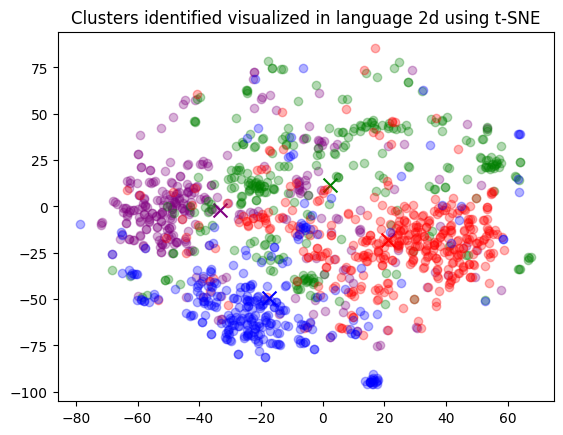

In [22]:
df_emb = pd.read_csv(emb_path)
plot(df_emb, 7)

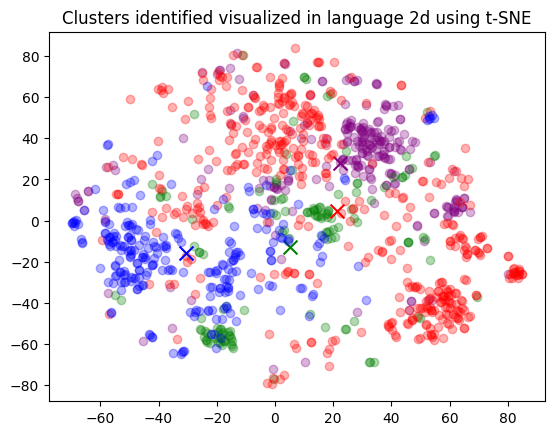

In [23]:
ext_emb = pd.read_csv(ext_emb_path)
plot(ext_emb, 9)

In [26]:
def explain(df, n_clusters, save_path):
    # Reading a review which belong to each group.
    rev_per_cluster = 5
    results = []

    for i in range(n_clusters):
        result = {}
        result["Cluster"] = i
        topics = "\n".join(
            df[df.Cluster == i]
            .combined.str.replace("Topic: ", "")
            .str.replace("\n\Topic: ", ":  ")
            .sample(rev_per_cluster, random_state=42)
            .values
        )

        messages = [
            {"role": "user", "content": f'What do the following topics have in common?\n\nTopics:\n"""\n{topics}\n"""\n\nTheme:'}
        ]

        response = client.chat.completions.create(
            model="gpt-4",
            messages=messages,
            temperature=0,
            max_tokens=64,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0)
        result["Theme"] = response.choices[0].message.content.replace("\n", "")

        sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
        result["Topics"] = sample_cluster_rows.Topic.str[:70].values.tolist()

        results.append(result)

    with open(save_path, "w") as f:
        json.dump(results, f, indent=4)


In [27]:
explain(ext_emb, 9, "data/css_speaker_topic_clusters_summary.json")